In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/benign-lung-tumor-generated-masks/kaggle/working/benign_masks/Bengin case (111).jpg
/kaggle/input/benign-lung-tumor-generated-masks/kaggle/working/benign_masks/Bengin case (85).jpg
/kaggle/input/benign-lung-tumor-generated-masks/kaggle/working/benign_masks/000075_1.jpg
/kaggle/input/benign-lung-tumor-generated-masks/kaggle/working/benign_masks/Bengin case (83).jpg
/kaggle/input/benign-lung-tumor-generated-masks/kaggle/working/benign_masks/Bengin case (61).jpg
/kaggle/input/benign-lung-tumor-generated-masks/kaggle/working/benign_masks/Bengin case (116).jpg
/kaggle/input/benign-lung-tumor-generated-masks/kaggle/working/benign_masks/Bengin case (86).jpg
/kaggle/input/benign-lung-tumor-generated-masks/kaggle/working/benign_masks/img-00045-00001.jpg
/kaggle/input/benign-lung-tumor-generated-masks/kaggle/working/benign_masks/img-00044-00001.jpg
/kaggle/input/benign-lung-tumor-generated-masks/kaggle/working/benign_masks/Bengin case (84).jpg
/kaggle/input/benign-lung-tumor-genera

In [3]:
import cv2
def CLAHE(img):
    clahe = cv2.createCLAHE(clipLimit=4, tileGridSize = (5,5))
    img = clahe.apply(img)
    return img

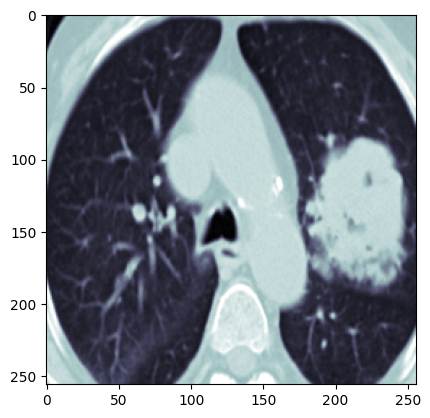

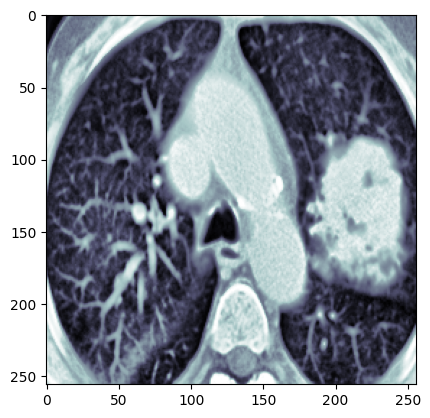

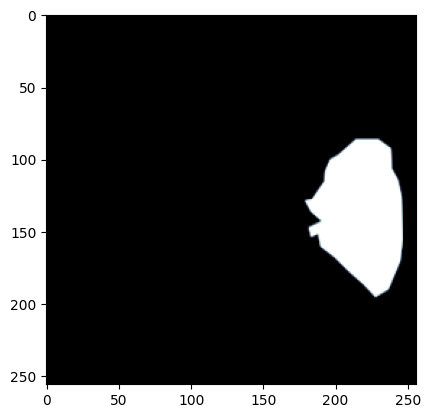

(256, 256, 1)
(256, 256)


In [3]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("/kaggle/input/lung-cancer-dataset/Lung cancer Dataset/Malignant/Malignant_images/Malignant case (10)CroppedResized.jpg",cv2.IMREAD_GRAYSCALE)
image = np.expand_dims(image,axis=-1)
image_ = CLAHE(image)
mask = cv2.imread("/kaggle/input/lung-cancer-dataset/Lung cancer Dataset/Malignant/Malignant_masks/Malignant case (10)CroppedResized.jpg",cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap='bone')
plt.show()
plt.imshow(image_,cmap='bone')
plt.show()
plt.imshow(mask,cmap='bone')
plt.show()

print(image.shape)
print(mask.shape)

#better not use CLAHE it seems!!

# This is for the binary dataset: "lung cancer dataset"

In [4]:
# This script generates a table which maps the entries in the lung cancer dataset...this dataset has got only two classes: [Benign, Malignant]
import os
import pandas as pd
import tensorflow as tf
# Define the paths to the directories
malignant_images_path = '/kaggle/input/lung-cancer-dataset/Lung cancer Dataset/Malignant/Malignant_images'
malignant_masks_path = '/kaggle/input/lung-cancer-dataset/Lung cancer Dataset/Malignant/Malignant_masks'
normal_images_path = '/kaggle/input/lung-cancer-dataset/Lung cancer Dataset/Normal/Normal_images'

# Initialize lists to store the data
data = {'Image_Path': [], 'Mask_Path': [], 'Label': []}

# Retrieve the paths and labels for the malignant images and masks
malignant_images = os.listdir(malignant_images_path)
malignant_masks = os.listdir(malignant_masks_path)

# Create the table for the malignant images and masks
for image in malignant_images:
    image_path = os.path.join(malignant_images_path, image)
    mask_path = os.path.join(malignant_masks_path, image) if image in malignant_masks else None
    data['Image_Path'].append(image_path)
    data['Mask_Path'].append(mask_path)
    data['Label'].append(1)  # Label 1 for malignant

# Create the table for the normal images
normal_images = os.listdir(normal_images_path)
for image in normal_images:
    image_path = os.path.join(normal_images_path, image)
    data['Image_Path'].append(image_path)
    data['Mask_Path'].append(None)  # No mask for normal images
    data['Label'].append(0)  # Label 0 for normal

# Create a Pandas DataFrame from the data
df = pd.DataFrame(data)

# Display the DataFrame
#print(df.head(5))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
#sanity check
print(df['Image_Path'][0])
print(df['Mask_Path'][0])
print(len(df['Mask_Path']))
print(len(df['Image_Path']))

/kaggle/input/lung-cancer-dataset/Lung cancer Dataset/Malignant/Malignant_images/Malignant case (427)CroppedResizedvflip.jpg
/kaggle/input/lung-cancer-dataset/Lung cancer Dataset/Malignant/Malignant_masks/Malignant case (427)CroppedResizedvflip.jpg
1640
1640


In [6]:
#I found that for the lung cancer dataset multiple copies of the same image were there for the malignant class. So I decided to filter out some of those entries to get a more balanced distribution 
import random

df_filtered = df.copy()
for index, row in df.iterrows():
    if row['Label'] == 1:  # Only for malignant cases
        if not row['Image_Path'].endswith("CroppedResized.jpg"):
            # Introduce a random variable to determine if the row will be dropped
            random_variable = random.choice([True, False])
            if random_variable:
                df_filtered.drop(index, inplace=True)
print(len(df_filtered['Image_Path']))

1109


In [7]:
print(df_filtered['Label'].value_counts())

Label
1    693
0    416
Name: count, dtype: int64


# This is for the balanced dataset with three classes: "lung cancer balanced dataset"

In [2]:
# This script generates a table which maps the entries in the "Balanced lung cancer dataset"...this dataset has got only two classes: [Benign, Malignant, Normal]
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
# Define the paths to the directories
malignant_images_path = '/kaggle/input/lung-cancer-balanced-dataset/Dataset - Copy/Malignant/images_new'
malignant_masks_path = '/kaggle/input/lung-cancer-balanced-dataset/Dataset - Copy/Malignant/mask_new'
benign_images_path = "/kaggle/input/lung-cancer-balanced-dataset/Dataset - Copy/Benign_new/images"
benign_masks_path  = "/kaggle/input/lung-cancer-balanced-dataset/Dataset - Copy/Benign_new/masks"
normal_images_path = '/kaggle/input/lung-cancer-balanced-dataset/Dataset - Copy/Normal'

# Initialize lists to store the data
data = {'Image_Path': [], 'Mask_Path': [], 'Label': []}

# Retrieve the paths and labels for the malignant images and masks
malignant_images = os.listdir(malignant_images_path)
malignant_masks = os.listdir(malignant_masks_path)

# Creates table for the malignant images and masks
for image in tqdm(malignant_images):
    image_path = os.path.join(malignant_images_path, image)
    mask_path = os.path.join(malignant_masks_path, image) if image in malignant_masks else None
    data['Image_Path'].append(image_path)
    data['Mask_Path'].append(mask_path)
    data['Label'].append(2)  # Label 1 for malignant
    
benign_images = os.listdir(benign_images_path)
benign_masks = os.listdir(benign_masks_path)

# Creates table for the benign images and masks
for image in tqdm(benign_images):
    image_path = os.path.join(benign_images_path, image)
    mask_path = os.path.join(benign_masks_path, image) if image in benign_masks else None
    data['Image_Path'].append(image_path)
    data['Mask_Path'].append(mask_path)
    data['Label'].append(1)  # Label 1 for malignant

# Creates table for the normal images
normal_images = os.listdir(normal_images_path)
for image in tqdm(normal_images):
    image_path = os.path.join(normal_images_path, image)
    data['Image_Path'].append(image_path)
    data['Mask_Path'].append(None)  # No mask for normal images
    data['Label'].append(0)  # Label 0 for normal

# Create a Pandas DataFrame from the data
df = pd.DataFrame(data)

# Display the DataFrame
#print(df.head(5))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
100%|██████████| 416/416 [00:00<00:00, 203906.80it/s]


In [3]:
#sanity check
print(df['Image_Path'][0])
print(df['Mask_Path'][0])
print(len(df['Mask_Path']))
print(len(df['Image_Path']))

/kaggle/input/lung-cancer-balanced-dataset/Dataset - Copy/Malignant/images_new/Malignant case (289)CroppedResized.jpg
/kaggle/input/lung-cancer-balanced-dataset/Dataset - Copy/Malignant/mask_new/Malignant case (289)CroppedResized.jpg
1608
1608


In [4]:
print(df['Label'].value_counts())

Label
2    600
1    592
0    416
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split
df_shuffled = df.sample(frac=1, random_state=42)

# Split the data into training and testing sets
train_df, test_df = train_test_split(df_shuffled, test_size=0.2, stratify=df_shuffled['Label'], random_state=42)


In [44]:
#for multiclass
import cv2
import numpy as np
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()

class CustomDataGenerator(Sequence):
    def __init__(self, df, batch_size, image_size, shuffle=True,binary=True):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.binary=binary
        self.on_epoch_end()
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.RandomBrightnessContrast(p=0.2),
            A.Rotate(limit=10, p=0.3)
        ])

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []
        labels = []

        for i, row in batch_df.iterrows():
            if self.binary==True:
                image = cv2.imread(row['Image_Path'], cv2.IMREAD_GRAYSCALE)
            else:
                image = cv2.imread(row['Image_Path'], cv2.IMREAD_COLOR)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.image_size)
            #shape = image.shape
            #image = scaler.fit_transform(image.reshape(-1, shape[-1])).reshape(shape)
            image = image/255.0
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask_path = row['Mask_Path']
            if mask_path:
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, self.image_size)
                mask=mask/255.0
                mask[mask>0.7]=1
                #mask[mask>0.1]=1
            else:
                mask = np.zeros(self.image_size, dtype=np.uint8)

            label = row['Label']

            augmented = self.transform(image=image, mask=mask)
            images.append(augmented['image'])
            masks.append(augmented['mask'])
            if(label==2):
                labels.append([1,0,0])
            if(label==1):
                labels.append([0,1,0])
            if(label==0):
                labels.append([0,0,1])
                

        #images = np.expand_dims(np.array(images, dtype=np.float32), axis=-1)
        images = np.array(images, dtype=np.float32)
        masks = np.expand_dims(np.array(masks, dtype=np.float32), axis=-1)
        #labels = np.expand_dims(np.array(labels, dtype=np.float32),axis=-1)
        labels = np.array(labels,dtype=np.float32)

        #return {"input_9": images}, {"segmentation_output": masks, "classifier_output": labels}
        return  images, [masks, labels]

# Example usage of the CustomDataGenerator
train_generator = CustomDataGenerator(train_df, batch_size=8, image_size=(256, 256), shuffle=True, binary=True)

In [ ]:
#for binary
import cv2
import numpy as np
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()

class CustomDataGenerator(Sequence):
    def __init__(self, df, batch_size, image_size, shuffle=True):
        self.df = df
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.RandomBrightnessContrast(p=0.2),
            A.Rotate(limit=10, p=0.3)
        ])

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []
        labels = []

        for i, row in batch_df.iterrows():
            
            #image = cv2.imread(row['Image_Path'], cv2.IMREAD_GRAYSCALE)
            image = cv2.imread(row['Image_Path'], cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.image_size)
            #shape = image.shape
            #image = scaler.fit_transform(image.reshape(-1, shape[-1])).reshape(shape)
            image = image/255.0
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            mask_path = row['Mask_Path']
            if mask_path:
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, self.image_size)
                mask=mask/255.0
                mask[mask>0.7]=1
                #mask[mask>0.1]=1
            else:
                mask = np.zeros(self.image_size, dtype=np.uint8)

            label = row['Label']

            augmented = self.transform(image=image, mask=mask)
            images.append(augmented['image'])
            masks.append(augmented['mask'])
            labels.append(label)

        #images = np.expand_dims(np.array(images, dtype=np.float32), axis=-1)
        images = np.array(images, dtype=np.float32)
        masks = np.expand_dims(np.array(masks, dtype=np.float32), axis=-1)
        labels = np.expand_dims(np.array(labels, dtype=np.float32),axis=-1)

        #return {"input_9": images}, {"segmentation_output": masks, "classifier_output": labels}
        return  images, [masks, labels]

# Example usage of the CustomDataGenerator
train_generator = CustomDataGenerator(train_df, batch_size=8, image_size=(256, 256), shuffle=True)

[1. 0. 0.]
[0. 0. 1.]
[1. 0. 0.]
[0. 1. 0.]
[0. 1. 0.]
[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]


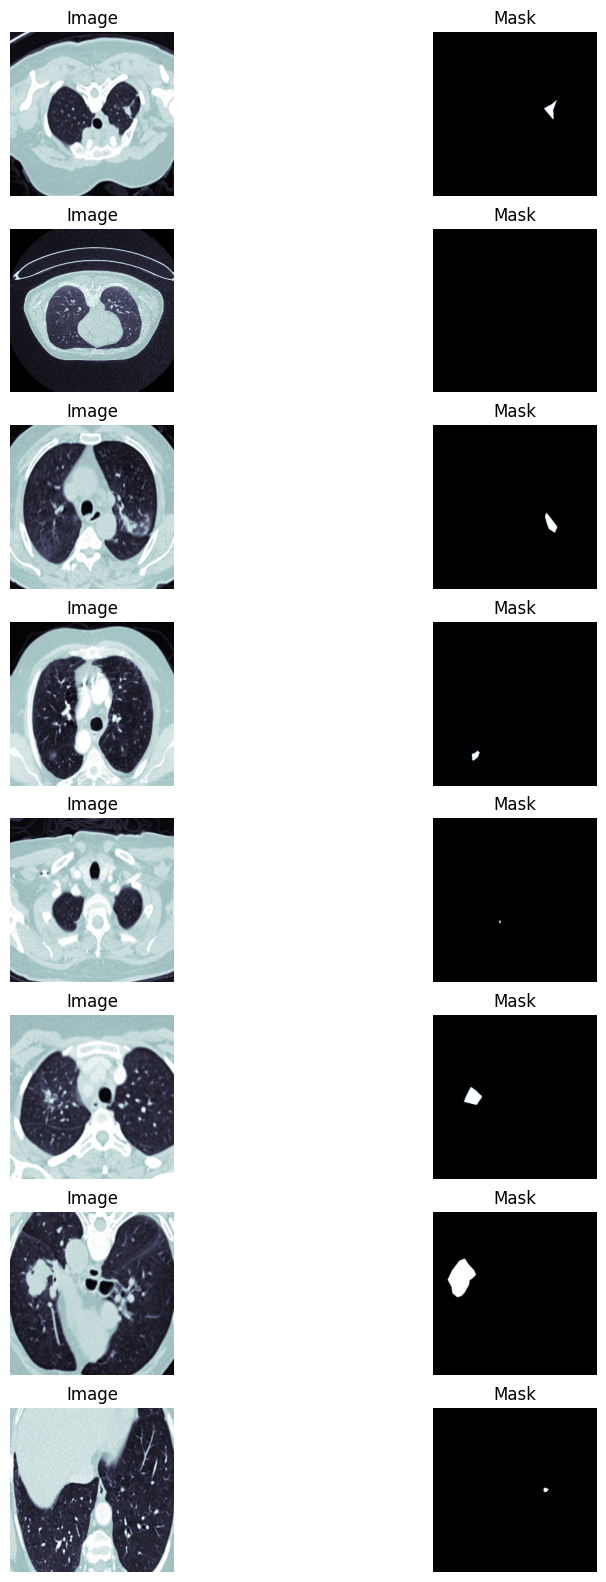

In [45]:
import matplotlib.pyplot as plt

# Load a single batch
batch = train_generator[0]  # Assuming you want to load the first batch

# Extract images and labels from the batch
images, labels = batch

# Display the images and masks
n_images_to_display = len(images)
fig, ax = plt.subplots(n_images_to_display, 2, figsize=(10, 20))
for i in range(n_images_to_display):
    print(labels[1][i])
    ax[i, 0].imshow(images[i], cmap='bone')
    ax[i, 0].set_title('Image')
    ax[i, 1].imshow(labels[0][i], cmap='bone')
    ax[i, 1].set_title('Mask')

    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
plt.show()

In [11]:
images.shape

(8, 256, 256, 3)

In [32]:
#defining model architecture for resnet50_UNet
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def conv_block(inputs, num_filters):
    x = BatchNormalization()(inputs)
    s = Conv2D(num_filters, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same",kernel_initializer="he_normal")(x)
    x = Dropout(0.1)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same",kernel_initializer="he_normal")(x)

    return x + s

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    for layer in resnet50.layers:
        layer.trainable=True

    """ Encoder """
    s1 = resnet50.get_layer("input_5").output           ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
    
    """Classifier"""
    classifier_arm = Flatten()(b1)
    classifier_arm = Dense(256, activation='relu')(classifier_arm)
    classifier_output = Dense(3, activation='softmax', name='classifier_output')(classifier_arm)

    """ Seg_Output """
    segmentation_output = Conv2D(1, 1, padding="same", activation="sigmoid",name = 'segmentation_output')(d4)

    model = Model(inputs=inputs, outputs=[segmentation_output, classifier_output], name="composite_model")
    return model


In [8]:
!pip -q install tensorflow-wavelets

In [10]:
import tensorflow_wavelets.Layers.DWT as DWT
import tensorflow_wavelets.Layers.DTCWT as DTCWT
import tensorflow_wavelets.Layers.DMWT as DMWT

In [11]:
tf.config.run_functions_eagerly(True)

In [46]:

import pywt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow_wavelets.utils.helpers import *
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # for tensor flow warning
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


class DWT(layers.Layer):
    """
    Discrete Wavelet transform - tensorflow - keras
    inputs:
        name - wavelet name ( from pywavelet library)
        concat - 1 - merge transform output to one channel
               - 0 - split to 4 channels ( 1 img in -> 4 smaller img out)
    """

    def __init__(self, wavelet_name='haar', concat=1, **kwargs):
        super(DWT, self).__init__(**kwargs)
        # self._name = self.name + "_" + name
        # get filter coeffs from 3rd party lib
        wavelet = pywt.Wavelet(wavelet_name)
        self.dec_len = wavelet.dec_len
        self.concat = concat
        # decomposition filter low pass and hight pass coeffs
        db2_lpf = wavelet.dec_lo
        db2_hpf = wavelet.dec_hi

        # covert filters into tensors and reshape for convolution math
        db2_lpf = tf.constant(db2_lpf[::-1])
        self.db2_lpf = tf.reshape(db2_lpf, (1, wavelet.dec_len, 1, 1))

        db2_hpf = tf.constant(db2_hpf[::-1])
        self.db2_hpf = tf.reshape(db2_hpf, (1, wavelet.dec_len, 1, 1))

        self.conv_type = "VALID"
        self.border_padd = "SYMMETRIC"

    def build(self, input_shape):
        # filter dims should be bigger if input is not gray scale
        if input_shape[-1] != 1:
            # self.db2_lpf = tf.repeat(self.db2_lpf, input_shape[-1], axis=-1)
            self.db2_lpf = tf.keras.backend.repeat_elements(self.db2_lpf, input_shape[-1], axis=-1)
            # self.db2_hpf = tf.repeat(self.db2_hpf, input_shape[-1], axis=-1)
            self.db2_hpf = tf.keras.backend.repeat_elements(self.db2_hpf, input_shape[-1], axis=-1)

    def call(self, inputs, training=None, mask=None):

        # border padding symatric add coulums
        inputs_pad = tf.pad(inputs, [[0, 0], [0, 0], [self.dec_len-1, self.dec_len-1], [0, 0]], self.border_padd)

        # approximation conv only rows
        a = tf.nn.conv2d(
            inputs_pad, self.db2_lpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # details conv only rows
        d = tf.nn.conv2d(
            inputs_pad, self.db2_hpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # ds - down sample
        a_ds = a[:, :, 1:a.shape[2]:2, :]
        d_ds = d[:, :, 1:d.shape[2]:2, :]

        # border padding symatric add rows
        a_ds_pad = tf.pad(a_ds, [[0, 0], [self.dec_len-1, self.dec_len-1], [0, 0], [0, 0]], self.border_padd)
        d_ds_pad = tf.pad(d_ds, [[0, 0], [self.dec_len-1, self.dec_len-1], [0, 0], [0, 0]], self.border_padd)

        # convolution is done on the rows so we need to
        # transpose the matrix in order to convolve the colums
        a_ds_pad = tf.transpose(a_ds_pad, perm=[0, 2, 1, 3])
        d_ds_pad = tf.transpose(d_ds_pad, perm=[0, 2, 1, 3])

        # aa approximation approximation
        aa = tf.nn.conv2d(
            a_ds_pad, self.db2_lpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # ad approximation details
        ad = tf.nn.conv2d(
            a_ds_pad, self.db2_hpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # ad details aproximation
        da = tf.nn.conv2d(
            d_ds_pad, self.db2_lpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )
        # dd details details
        dd = tf.nn.conv2d(
            d_ds_pad, self.db2_hpf, padding=self.conv_type, strides=[1, 1, 1, 1],
        )

        # transpose back the matrix
        aa = tf.transpose(aa, perm=[0, 2, 1, 3])
        ad = tf.transpose(ad, perm=[0, 2, 1, 3])
        da = tf.transpose(da, perm=[0, 2, 1, 3])
        dd = tf.transpose(dd, perm=[0, 2, 1, 3])

        # down sample
        ll = aa[:, 1:aa.shape[1]:2, :, :]
        lh = ad[:, 1:ad.shape[1]:2, :, :]
        hl = da[:, 1:da.shape[1]:2, :, :]
        hh = dd[:, 1:dd.shape[1]:2, :, :]

        # concate all outputs ionto tensor
        if self.concat == 0:
            x = tf.concat([ll, lh, hl, hh], axis=-1)
            #x = tf.concat([ll, lh, hl], axis=-1)
        else:
            #x = tf.concat([tf.concat([ll, lh], axis=1), tf.concat([hl, hh], axis=1)], axis=2)
            x = ll
        return x


In [47]:
def GCSE(input_tensor, ratio=16):
    
  
    # Compute the global statistics (mean and std deviation) along the channel axis.
    mean = tf.reduce_mean(input_tensor, axis=[1, 2], keepdims=True)
    std = tf.math.reduce_std(input_tensor, axis=[1, 2], keepdims=True)
    
    # Compute channel-wise attention using a convolutional neural network.
    attn_channel = tf.concat([mean, std], axis=-1)
    attn_channel = tf.keras.layers.Conv2D(filters=input_tensor.shape[-1] // ratio, kernel_size=(1, 1), activation='relu')(attn_channel)
    attn_channel = tf.keras.layers.Conv2D(filters=input_tensor.shape[-1], kernel_size=(1, 1), activation='sigmoid')(attn_channel)
    
    # Compute spatial attention using global information from the input tensor.
    global_info = tf.reduce_mean(input_tensor, axis=-1, keepdims=True)
    attn_spatial = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(global_info)
    
    # Combine channel-wise and spatial attention.
    attn = tf.keras.layers.Multiply()([attn_channel,attn_spatial])
    
    # Multiply the input tensor by the learned attention weights.
    output_tensor = tf.keras.layers.Multiply()([input_tensor,attn])
    
    return output_tensor

In [60]:
#Architecture for Residual_UNet with DWT pooling
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, ZeroPadding2D,Dropout,Dense,MaxPooling2D,Reshape,Multiply,GlobalAveragePooling2D,AveragePooling2D,Lambda,Flatten
from tensorflow.keras.models import Model
import pywt
from keras.layers import Lambda

def batchnorm_relu(inputs):
    x = BatchNormalization(axis=-1)(inputs)
    x = Activation("relu")(x)
    return x

def residual_block(inputs, num_filters):
    """ Convolutional Layer """
    x = batchnorm_relu(inputs)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)
    x = Dropout(0.1)(x)
    x = batchnorm_relu(x)
    x = Conv2D(num_filters, 3, padding="same", strides=1,kernel_initializer = "he_normal")(x)

    """ Shortcut Connection """
    s = Conv2D(num_filters, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = x + s
    return x

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters,2, strides=(2,2), kernel_initializer="he_normal",padding = "same")(inputs)
    x = Concatenate()([x, skip_features])
    x = residual_block(x, num_filters)
    x = GCSE(x)
    return x

def build_Y_Net_np(input_shape):
    inputs = Input(input_shape)
    
    #integrating augmentation directly into the model
    #x = tf.keras.layers.RandomContrast(0.15)(inputs)
    #x = tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)(x)
    #x = tf.keras.layers.RandomFlip("horizontal_and_vertical")(x)
    #x_ = tf.keras.layers.RandomZoom(0.3)(x)
    f = [16 , 32, 64, 128]

    """ Encoder 1 """
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = batchnorm_relu(x)
    x = Conv2D(f[0], 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    s = Conv2D(f[0], 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    
    c1 = x + s
    #c1 = GCSE(c1)
    #p1 = Lambda(lambda x: DWT.DWT(wavelet_name="db1", concat=1)(x), name='DWT_1')(c1)[:,0:128,0:128,:]
    #p1 = Lambda(lambda x: wavelet_downsampling(x))(c1)
    #p1_lambda = DWTLayer(wavelet_name="db1", concat=1, name='DWT_1')(c1)
    #p1 = p1_lambda[:, 0:128, 0:128, :]
    #p1_ = DWT.DWT(name="db1",concat=1)(c1)
    #p1 = p1_[:,0:128,0:128,:]
    #p1 = WaveletDownsampling()(c1)
    p1 = DWT(wavelet_name='db1', concat=0, name='pool_1')(c1)
    p1 = GCSE(p1)
    #p1 = MaxPooling2D((2,2))(c1)
    s1 = c1

    """ Encoder 2 and 3 """
    c2 = residual_block(p1, f[1])
    #c2 = GCSE(c2)
    #p2 = Lambda(lambda x: DWT.DWT(wavelet_name="db1", concat=1)(x), name='DWT_2')(c2)[:,0:64,0:64,:]
    #p2 = Lambda(lambda x: pywt.dwt2(x,'db1')[0], name='DWT_2')(c2)
    #p2 = DWTLayer(wavelet_name="db1", concat=1, name='DWT_1')((c2))[:,0:64,0:64,:]
    p2 = DWT(wavelet_name="db1",concat=0,name = 'pool_2')(c2)
    p2 = GCSE(p2)
    #p2 = MaxPooling2D((2,2))(c2)
    #p2 = p2_[:,0:64,0:64,:]
    s2 = c2
    
    c3 = residual_block(p2, f[2])
    #c3 = GCSE(c3)
    #p3 = Lambda(lambda x: DWT.DWT(wavelet_name="db1", concat=1)(x), name='DWT_3')(c3)[:,0:32,0:32,:]
    #p3 = Lambda(lambda x: pywt.dwt2(x,'db1')[0], name='DWT_3')(c3)
    #p3 = DWTLayer(wavelet_name="db1", concat=1, name='DWT_1')(c3)[:,0:32,0:32,:]
    p3 = DWT(wavelet_name="db1",concat=0,name = 'pool_3')(c3)
    p3 = GCSE(p3)
    #p3 = MaxPooling2D((2,2))(c3)
    s3 = c3

    c4 = residual_block(p3, f[3])
    #c4 = GCSE(c4)
    #p4 = Lambda(lambda x: DWT.DWT(wavelet_name="db1", concat=1)(x), name='DWT_4')(c4)[:,0:16,0:16,:]
    #p4 = Lambda(lambda x: pywt.dwt2(x,'db1')[0], name='DWT_4')(c4)
    #p4 = DWTLayer(wavelet_name="db1", concat=1, name='DWT_1')(c4)[:,0:16,0:16,:]
    p4 = DWT(wavelet_name="db1",concat=0,name = 'pool_4')(c4)
    p4 = GCSE(p4)
    #p4= MaxPooling2D((2,2))(c4)
    s4 = c4

    """ Bridge """
    b = residual_block(p4,256)
    #b = p4

    """ Decoder 1, 2, 3 """
    d1 = decoder_block(b, s4, f[3])
    d2 = decoder_block(d1, s3, f[2])
    d3 = decoder_block(d2, s2, f[1])
    d4 = decoder_block(d3, s1, f[0])

    """Classifier"""
    """"classifier_arm = Flatten()(b)
        classifier_arm = Dense(f[2], activation='relu')(classifier_arm)
        classifier_output = Dense(3, activation='softmax', name='classifier_output')(classifier_arm)"""
    l1 = GlobalAveragePooling2D()(b)
    l2 = GlobalAveragePooling2D()(d4)
    classifier_arm = Concatenate()([l1,l2])
    classifier_arm = Dense(f[2], activation='relu')(classifier_arm)
    classifier_output = Dense(3, activation='softmax', name='classifier_output')(classifier_arm)

    """ Seg_Output """
    segmentation_output = Conv2D(1, 1, padding="same", activation="sigmoid",name = 'segmentation_output')(d4)

    model = Model(inputs=inputs, outputs=[segmentation_output, classifier_output], name="composite_model")
    return model


In [80]:
#defining model architecture for Resnet_50_DWT_UNet...pretrained on imagenet
#I find this to a continuation of the W-Net in many ways...instead of using two encoders were basically breaking open a pretrained encoder to integrate blocks that will be trained from scratch
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def conv_block(inputs, num_filters):
    x = BatchNormalization()(inputs)
    s = Conv2D(num_filters, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same",kernel_initializer="he_normal")(x)
    x = Dropout(0.01)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same",kernel_initializer="he_normal")(x)

    return x + s

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def DWT_pooling_block(inputs,num_filters,i):
    #there were instantiation issues while using this custom defined layer...so each layer has to be given a name manually...i is for that 
    #purpose
    p = DWT(wavelet_name="db1",concat=0,name = 'pool_'+ str(i))(inputs)
    p = conv_block(p,num_filters)
    return p
    
def build_Y_Net(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    for layer in resnet50.layers:
        layer.trainable=True
        
    """Encoder 1"""
    x = Conv2D(64, 3, padding="same", strides=1,kernel_initializer="he_normal")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(64, 3, padding="same", strides=1,kernel_initializer="he_normal")(x)
    s = Conv2D(64, 1, padding="same", strides=1,kernel_initializer="he_normal")(inputs)

    c1 = x + s
    p1 = DWT(wavelet_name='db1', concat=0, name='pool_1')(c1)#pooling operation
    s1 = c1# skip connection

    """Encoder 2"""
    c2 = conv_block(p1,128)
    p2 = DWT(wavelet_name='db1', concat=0, name='pool_2')(c2)#pooling operation....instantiation is important...name them correctly
    s2 = c2# skip connection 
    """Encoder 3"""
    block_1to3 = Model(inputs = resnet50.get_layer("conv2_block1_1_conv").input,outputs=resnet50.get_layer("conv2_block3_out").output)
    c3 = block_1to3(Conv2D(64, 1, padding="same", strides=1,kernel_initializer="he_normal")(p2))
    p3 = DWT(wavelet_name='db1', concat=0, name='pool_3')(c3)#pooling operation....instantiation is important...name them correctly
    s3 = c3# skip connection 
    """Encoder 4"""
    block_3to4 = Model(inputs = resnet50.get_layer("conv3_block2_1_conv").input,outputs=resnet50.get_layer("conv3_block4_out").output)
    c4 = block_3to4(Conv2D(512, 1, padding="same", strides=1,kernel_initializer="he_normal")(p3))
    p4 = DWT(wavelet_name='db1', concat=0, name='pool_4')(c4)#pooling operation....instantiation is important...name them correctly
    s4 = c4# skip connection 
    
    """Bottleneck"""
    block_4to6 = Model(inputs = resnet50.get_layer("conv4_block2_1_conv").input,outputs=resnet50.get_layer("conv4_block6_out").output)
    b = block_4to6(Conv2D(1024, 1, padding="same", strides=1,kernel_initializer="he_normal")(p4))

    """ Decoder """
    d1 = decoder_block(b, s4, 512)                     
    d2 = decoder_block(d1, s3, 256)                     
    d3 = decoder_block(d2, s2, 128)                    
    d4 = decoder_block(d3, s1, 64)                      
    
    """Classifier"""
    classifier_arm = Flatten()(b)
    classifier_arm = Dense(256, activation='relu')(classifier_arm)
    classifier_output = Dense(3, activation='softmax', name='classifier_output')(classifier_arm)

    """ Seg_Output """
    segmentation_output = Conv2D(1, 1, padding="same", activation="sigmoid",name = 'segmentation_output')(d4)

    model = Model(inputs=inputs, outputs=[segmentation_output, classifier_output], name="composite_model")
    return model

In [49]:
from keras import backend as K
epsilon = 1e-5
smooth = 1

def dice_coeff(y_true, y_pred, smooth=1):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    dice = (2. * intersection + smooth) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) + smooth)
    return dice
def dice_loss(y_true, y_pred, smooth=1):
    return  1- dice_coeff(y_true, y_pred, smooth=1)

def FocalLoss(targets, inputs, alpha=0.8, gamma=2):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return dice_loss(y_true, y_pred, smooth=1) + FocalLoss(y_true, y_pred, 0.25,2)
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou


In [61]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy
# Build the model
input_shape = (256,256,1)  # Assuming RGB images
model = build_Y_Net_np(input_shape)

In [62]:
# Compile the model
model.compile(optimizer=Adam(lr=1e-3),
              loss={'segmentation_output': total_loss, 'classifier_output': categorical_crossentropy},
              #loss_weights = {'segmentation_output': 1 , 'classifier_output': },
              metrics={'segmentation_output': [dice_coeff,iou,sensitivity,specificity], 'classifier_output': ['accuracy']})

In [63]:
model.summary()

Model: "composite_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_318 (Conv2D)            (None, 256, 256, 16  160         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_110 (Batch  (None, 256, 256, 16  64         ['conv2d_318[0][0]']             
 Normalization)                 )                                                   

In [64]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
import keras

csv_logger = CSVLogger('./training.log', separator=',', append=False)


callbacks = [
      keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001,
                             patience=9, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=4, min_lr=0.00001, verbose=1),
      keras.callbacks.ModelCheckpoint(filepath = './model_{epoch:03d}.h5',
                              verbose=1, save_best_only=True,save_weights_only = True),
      csv_logger
    ]


In [65]:
import tensorflow as tf
train_generator = CustomDataGenerator(train_df, batch_size=8, image_size=(256, 256), shuffle=True,binary=True)
val_generator = CustomDataGenerator(test_df, batch_size=8, image_size=(256, 256), shuffle=False,binary=True)

# Train the model
num_epochs = 50  # Define the number of epochs
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=num_epochs,
                    callbacks = callbacks,
                    verbose=1)

Epoch 1/50
161/161 [==============================] - ETA: 0s - loss: 1.5630 - segmentation_output_loss: 0.9060 - classifier_output_loss: 0.6570 - segmentation_output_dice_coeff: 0.1052 - segmentation_output_iou: 0.0268 - segmentation_output_sensitivity: 0.2476 - segmentation_output_specificity: 0.9758 - classifier_output_accuracy: 0.7628
Epoch 1: val_loss improved from inf to 4.04035, saving model to ./model_001.h5
161/161 [==============================] - 114s 706ms/step - loss: 1.5630 - segmentation_output_loss: 0.9060 - classifier_output_loss: 0.6570 - segmentation_output_dice_coeff: 0.1052 - segmentation_output_iou: 0.0268 - segmentation_output_sensitivity: 0.2476 - segmentation_output_specificity: 0.9758 - classifier_output_accuracy: 0.7628 - val_loss: 4.0404 - val_segmentation_output_loss: 1.0341 - val_classifier_output_loss: 3.0062 - val_segmentation_output_dice_coeff: 0.0303 - val_segmentation_output_iou: 0.0100 - val_segmentation_output_sensitivity: 0.1250 - val_segmentation

In [66]:
#history = pd.read_csv('/kaggle/input/final-model-and-log-100-epochs-wnet/training (3).log', sep=',', engine='python')

hist=history.history

############### ########## ####### #######

# hist=history.history


dice_coef=hist['segmentation_output_dice_coeff']
val_dice_coef=hist['val_segmentation_output_dice_coeff']

loss=hist['loss']
val_loss=hist['val_loss']

seg_loss=hist['segmentation_output_loss']
val_seg_loss=hist['val_segmentation_output_loss']

classification_loss=hist['classifier_output_loss']
val_classification_loss=hist['val_classifier_output_loss']

classification_acc=hist['classifier_output_accuracy']
val_classification_acc=hist['val_classifier_output_accuracy']

epoch=range(len(loss))



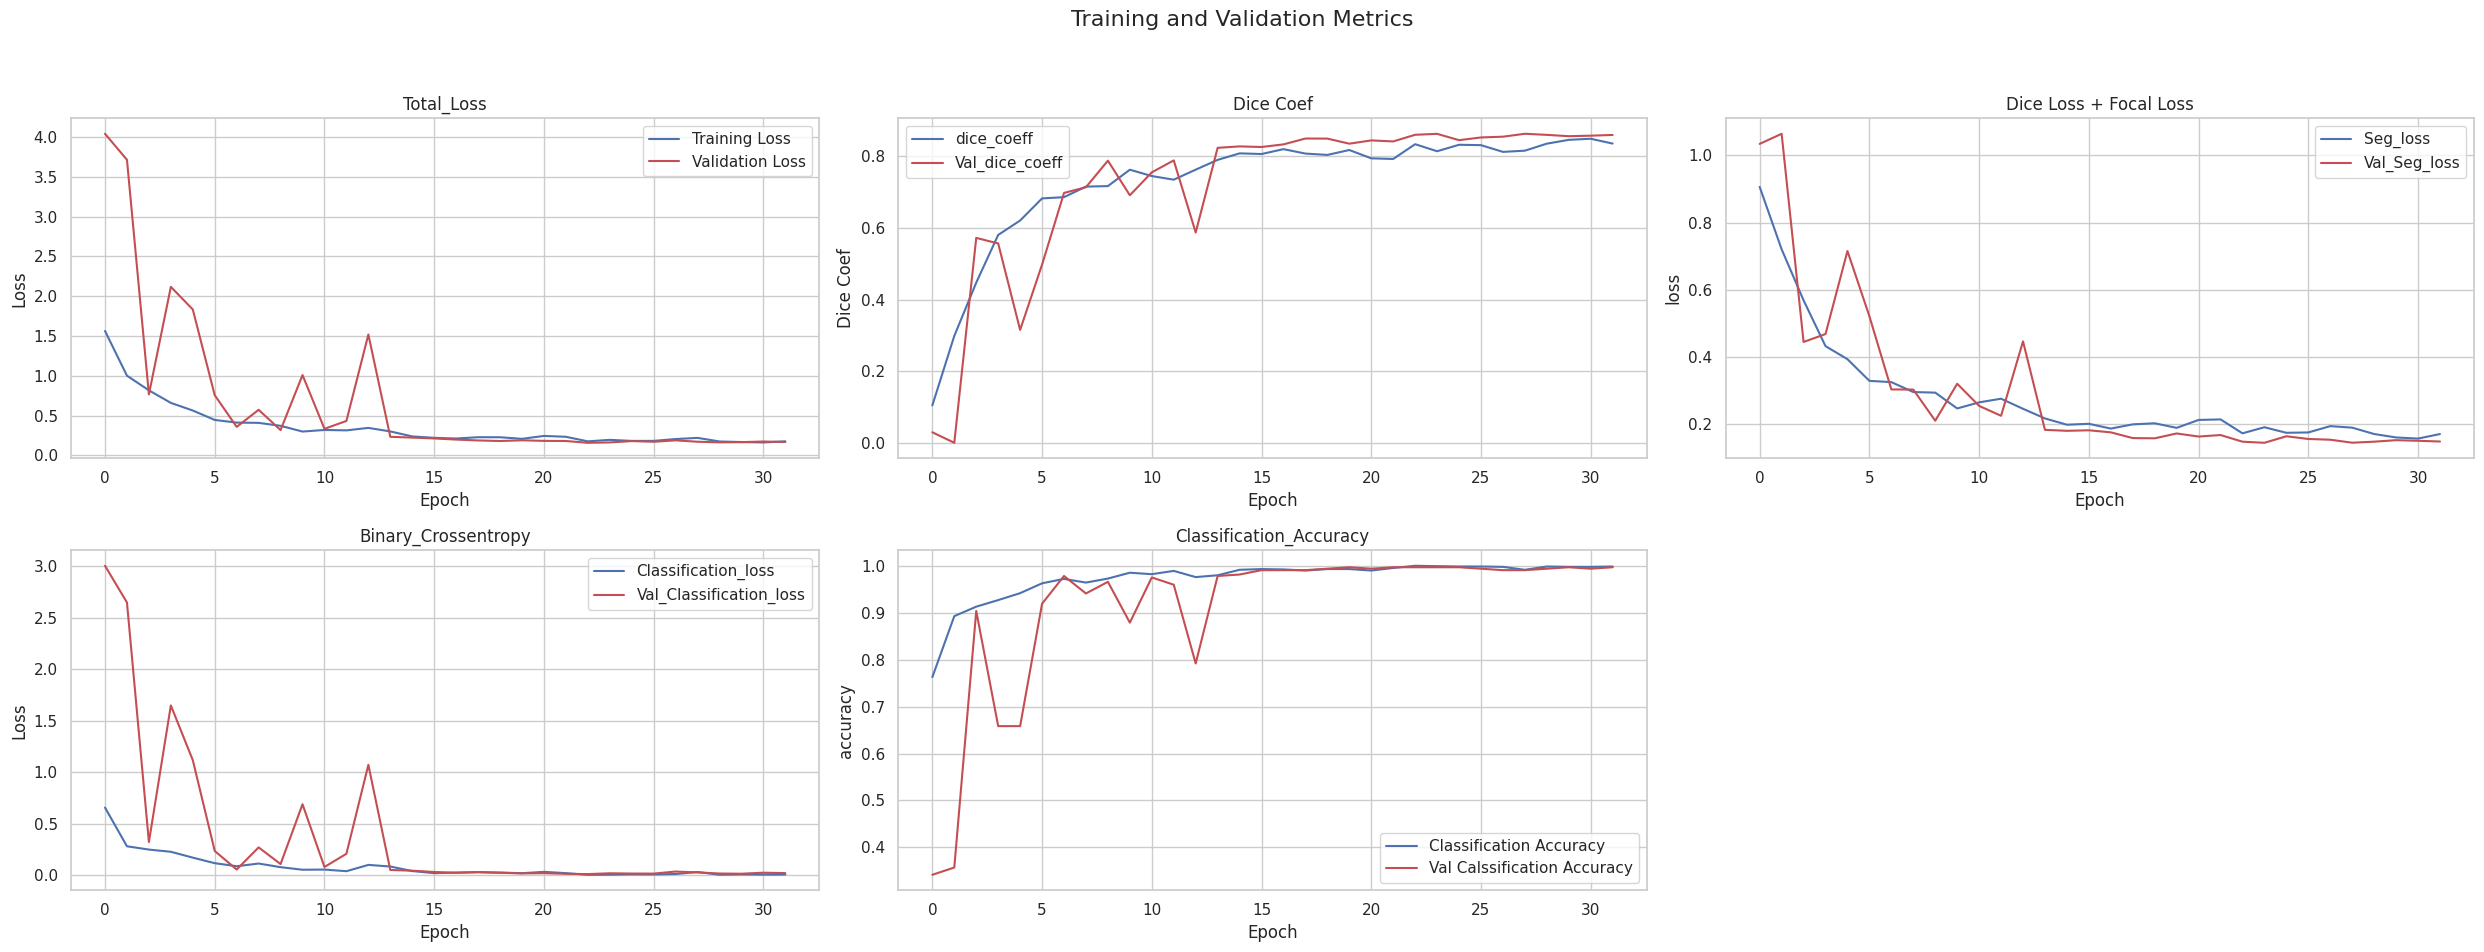

In [67]:
import seaborn as sns

# Assuming you've already read the CSV file into the 'hist' variable

sns.set(style="whitegrid")
plt.figure(figsize=(25, 10))
plt.suptitle('Training and Validation Metrics', fontsize=16)

# Training and Validation Loss
plt.subplot(2, 3, 1)
plt.plot(epoch, loss, 'b', label='Training Loss')
plt.plot(epoch, val_loss, 'r', label='Validation Loss')
plt.title('Total_Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training and Validation Dice Coef Liver
plt.subplot(2, 3, 2)
plt.plot(epoch, dice_coef, 'b', label='dice_coeff')
plt.plot(epoch, val_dice_coef, 'r', label='Val_dice_coeff')
plt.title('Dice Coef')
plt.xlabel('Epoch')
plt.ylabel('Dice Coef')
plt.legend()

# Training and Validation Dice Coef Tumor
plt.subplot(2, 3, 3)
plt.plot(epoch, seg_loss, 'b', label='Seg_loss')
plt.plot(epoch, val_seg_loss, 'r', label='Val_Seg_loss')
plt.title('Dice Loss + Focal Loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()

# Training and Validation IOU Tumor
plt.subplot(2, 3, 4)
plt.plot(epoch, classification_loss, 'b', label='Classification_loss')
plt.plot(epoch, val_classification_loss, 'r', label='Val_Classification_loss')
plt.title('Binary_Crossentropy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training and Validation IOU Liver
plt.subplot(2, 3, 5)
plt.plot(epoch, classification_acc, 'b', label='Classification Accuracy')
plt.plot(epoch, val_classification_acc, 'r', label='Val Calssification Accuracy')
plt.title('Classification_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [68]:
val_generator = CustomDataGenerator(test_df, batch_size=8, image_size=(256, 256), shuffle=False)
model.evaluate(val_generator)

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


41/41 [==============================] - 7s 163ms/step - loss: 0.1670 - segmentation_output_loss: 0.1477 - classifier_output_loss: 0.0193 - segmentation_output_dice_coeff: 0.8588 - segmentation_output_iou: 0.2701 - segmentation_output_sensitivity: 0.8408 - segmentation_output_specificity: 0.9987 - classifier_output_accuracy: 0.9969


[0.16701844334602356,
 0.14770075678825378,
 0.019317690283060074,
 0.8588246703147888,
 0.2700883746147156,
 0.8408231735229492,
 0.9987295866012573,
 0.9968944191932678]

# Testing on an Independent Dataset....images were annotated by SMCH

In [75]:
import os
import cv2
import numpy as np
import tensorflow as tf  # or any other framework you are using for the model
import matplotlib.pyplot as plt


# Replace 'input_folder' and 'output_folder' with the actual paths to your input and output folders
input_folder = '/kaggle/input/benign-dataset/Bengin cases'
output_mask_folder = './benign_masks'
output_img_folder = './benign_images'
if not os.path.exists(output_mask_folder):
    os.makedirs(output_mask_folder)
if not os.path.exists(output_img_folder):
    os.makedirs(output_img_folder)

# Loop through the images in the input folder

for image_file in os.listdir(input_folder):
    if image_file.endswith(".jpg"):
        # Read the input image
        img_path = os.path.join(input_folder, image_file)
        img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        target_size = 300
        h, w = img.shape

        # Calculate the starting and ending coordinates for the crop
        start_x = (w - target_size) // 2
        start_y = (h - target_size) // 2
        end_x = start_x + target_size
        end_y = start_y + target_size

        # Perform the center crop
        center_cropped_img = img[start_y:end_y, start_x:end_x]
        img = center_cropped_img
        img = cv2.resize(img, (256, 256))
        
        #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        """output_path = os.path.join(output_img_folder, image_file)
        cv2.imwrite(output_path, img_gray)"""
        
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = cv2.resize(img, (256, 256))
        img = img/255.0

        # Perform prediction
        
        prediction = model.predict(np.expand_dims(img, axis=0))[0]  # Make sure the input shape matches the model
        prediction_ = ((np.squeeze(prediction,axis=0)>0.7).astype(np.uint8))*255
        if np.any(prediction_ > 0):
            print('yes')
            """fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(img,cmap='gray')
            ax[0].set_title('Input Image')
            ax[0].axis('off')
            ax[1].imshow(prediction_, cmap='gray')  # You might need to adjust the cmap depending on your output format
            ax[1].set_title('Predicted Mask')
            ax[1].axis('off')
            plt.show()"""
            
            output_path = os.path.join(output_img_folder, image_file)
            cv2.imwrite(output_path, img_gray)

            output_path = os.path.join(output_mask_folder, image_file)
            cv2.imwrite(output_path, prediction_)

            print(f"Saved mask for {image_file} in {output_path}")


1/1 [==============================] - 0s 142ms/step
yes
Saved mask for Bengin case (78).jpg in ./benign_masks/Bengin case (78).jpg
1/1 [==============================] - 0s 134ms/step
yes
Saved mask for Bengin case (119).jpg in ./benign_masks/Bengin case (119).jpg
1/1 [==============================] - 0s 135ms/step
yes
Saved mask for Bengin case (90).jpg in ./benign_masks/Bengin case (90).jpg
1/1 [==============================] - 0s 136ms/step
yes
Saved mask for Bengin case (44).jpg in ./benign_masks/Bengin case (44).jpg
1/1 [==============================] - 0s 147ms/step
yes
Saved mask for Bengin case (87).jpg in ./benign_masks/Bengin case (87).jpg
1/1 [==============================] - 0s 136ms/step
yes
Saved mask for Bengin case (69).jpg in ./benign_masks/Bengin case (69).jpg
1/1 [==============================] - 0s 126ms/step
yes
Saved mask for Bengin case (64).jpg in ./benign_masks/Bengin case (64).jpg
1/1 [==============================] - 0s 131ms/step
yes
Saved mask for Be

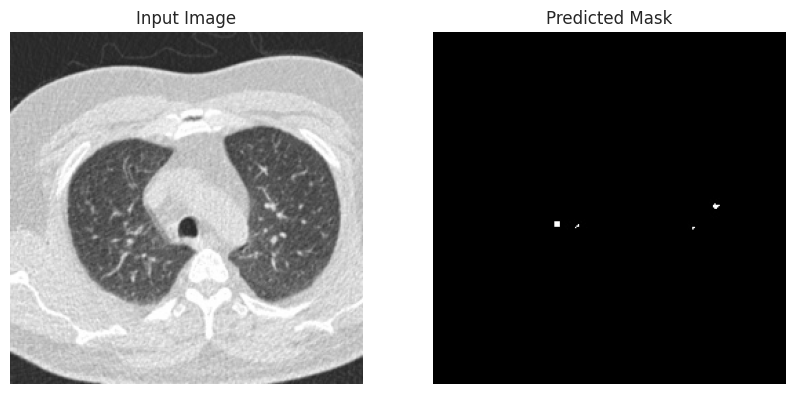

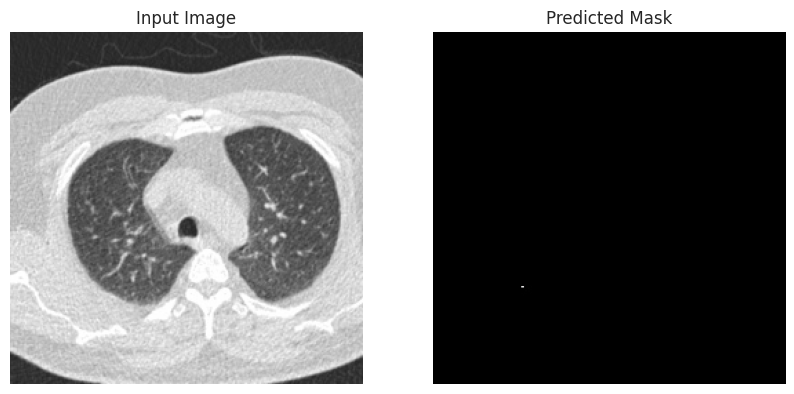

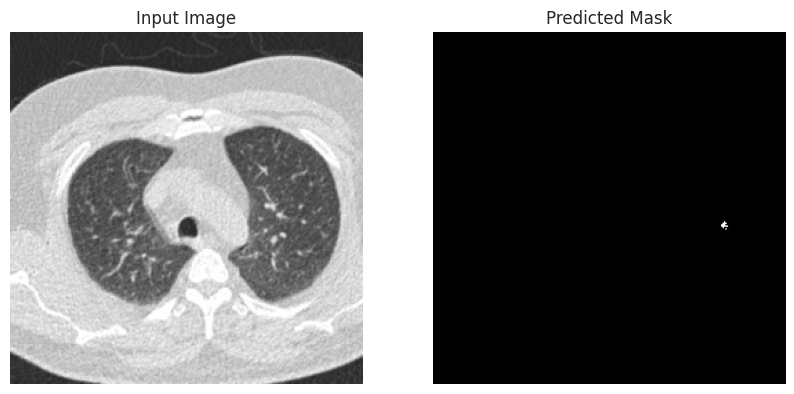

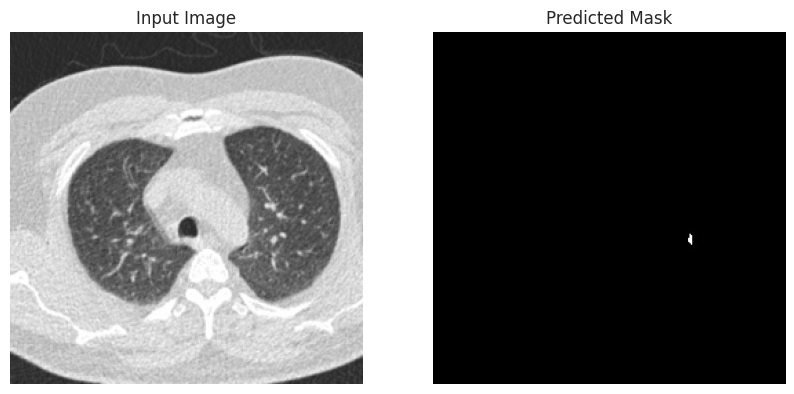

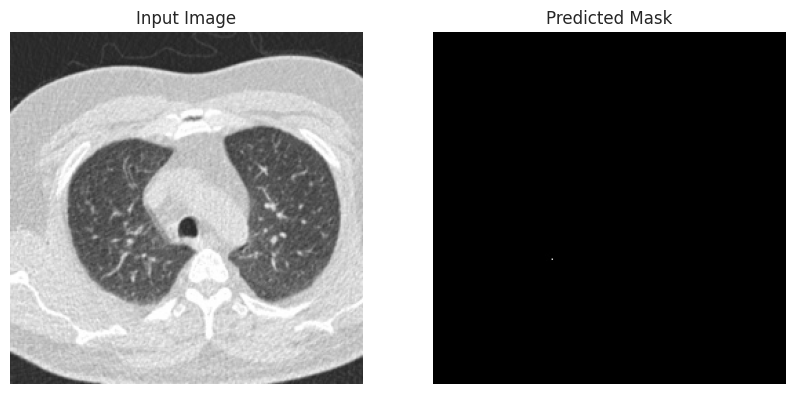

In [79]:
import random
# Randomly choose some images to display
num_images_to_display = 5 # Change this to the number of images you want to display
output_images = os.listdir(output_img_folder)
random_images = random.sample(output_images, num_images_to_display)

# Display the randomly chosen images along with their predicted masks
for random_image in random_images:
    img = cv2.imread(os.path.join(output_img_folder, random_image))
    mask = cv2.imread(os.path.join(output_mask_folder, random_image), cv2.IMREAD_GRAYSCALE)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Input Image')
    ax[0].axis('off')
    ax[1].imshow(mask, cmap='gray')  # You might need to adjust the cmap depending on your output format
    ax[1].set_title('Predicted Mask')
    ax[1].axis('off')

    plt.show()

1/1 [==============================] - 0s 138ms/step
(8, 256, 256, 1)


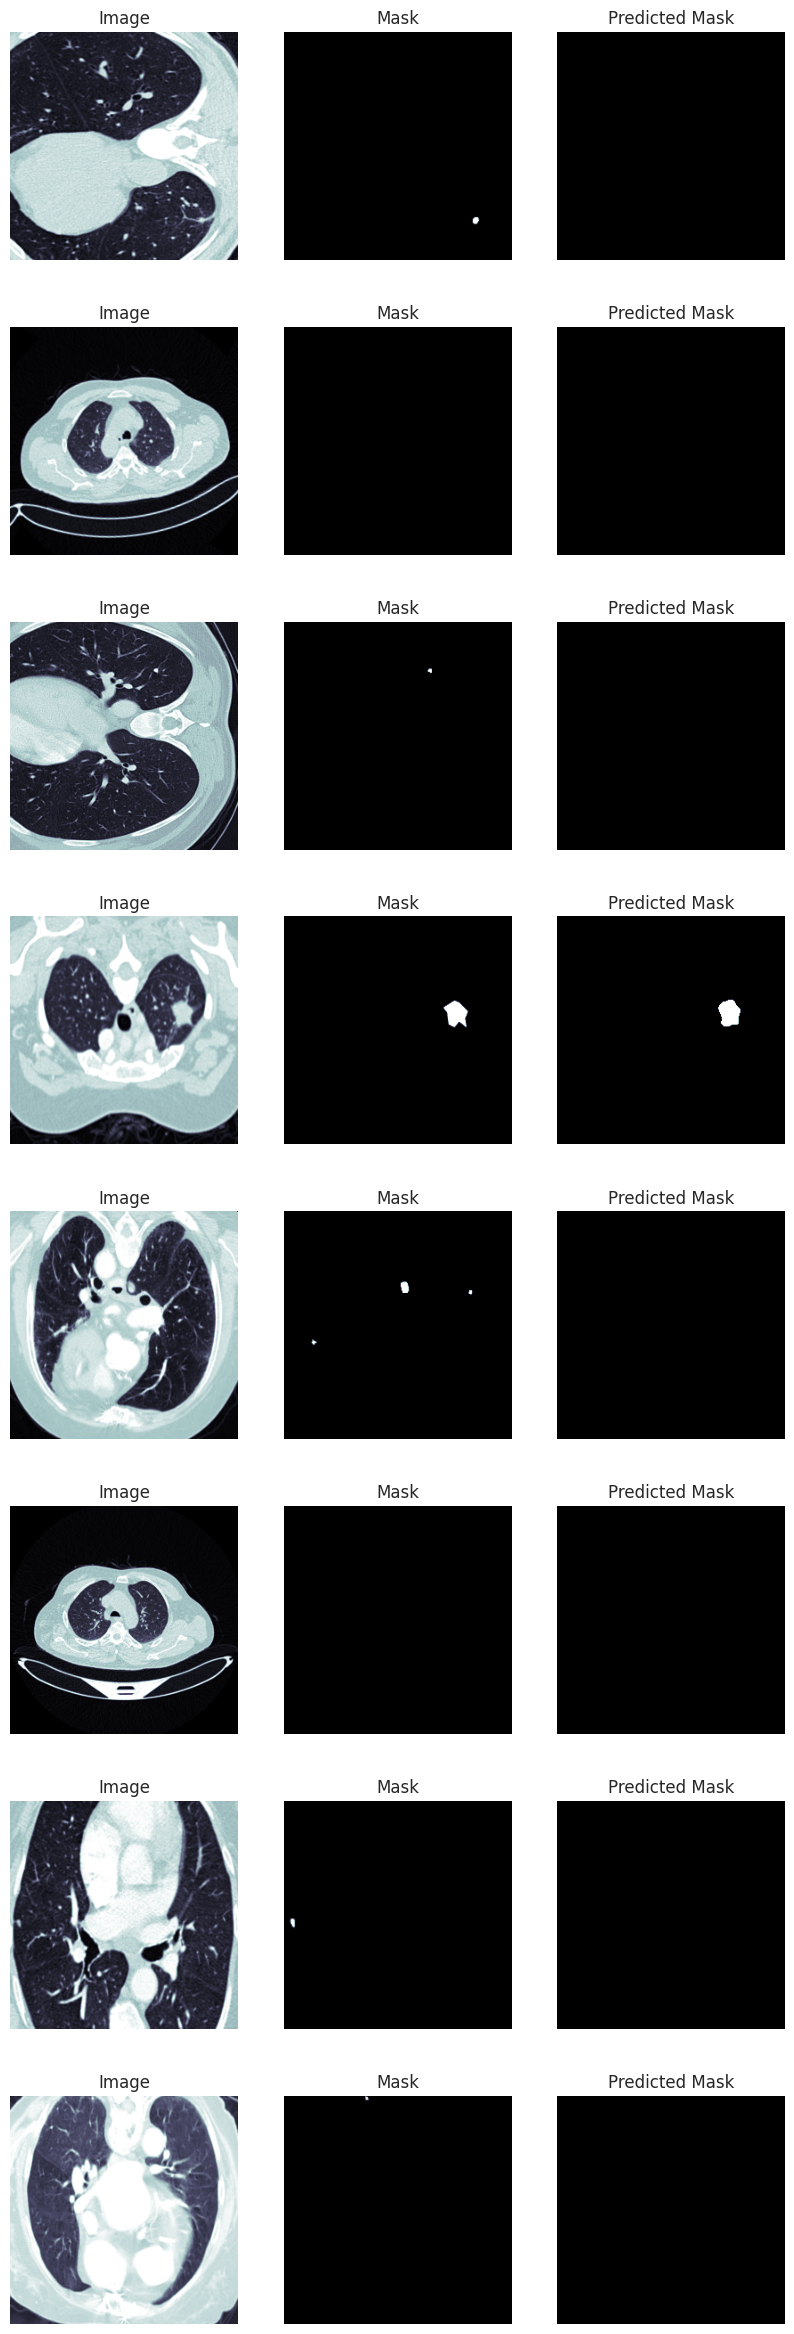

In [80]:

def generate_predictions(images, model):
    predictions = model.predict(images)
    return predictions

# Generate predictions
batch = train_generator[0] 
images, labels = batch
predictions = generate_predictions(images, model)
print(predictions[0].shape)

# Display the images, masks, and predicted masks
n_images_to_display = images.shape[0]
fig, ax = plt.subplots(n_images_to_display, 3, figsize=(10,30))
for i in range(n_images_to_display):
    ax[i, 0].imshow(images[i], cmap='bone')
    ax[i, 0].set_title('Image')
    ax[i, 1].imshow(labels[0][i], cmap='bone')
    ax[i, 1].set_title('Mask')
    ax[i, 2].imshow((predictions[0][i]>0.5), cmap='bone')  # Adjust the cmap depending on your output format
    ax[i, 2].set_title('Predicted Mask')

    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
plt.show()


In [81]:
import os
import shutil

# Clear the contents of the working directory
folder = '/kaggle/working'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

In [82]:
target_size = 300
img = cv2.imread("/kaggle/input/benign-but-annotated/Benign 2/000001.jpg",cv2.IMREAD_COLOR)
h, w, _ = img.shape

# Calculate the starting and ending coordinates for the crop
start_x = (w - target_size) // 2
start_y = (h - target_size) // 2
end_x = start_x + target_size
end_y = start_y + target_size

# Perform the center crop
center_cropped_img = img[start_y:end_y, start_x:end_x]

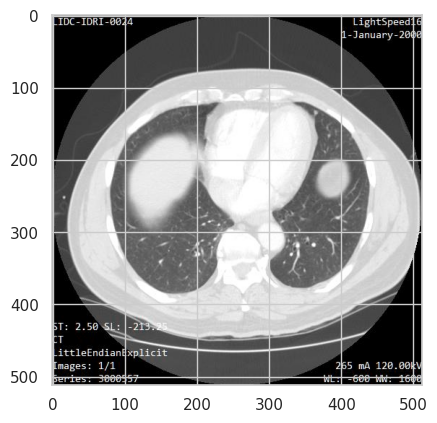

In [83]:
plt.imshow(img,cmap='gray')

In [84]:
center_cropped_img.shape

(300, 300, 3)

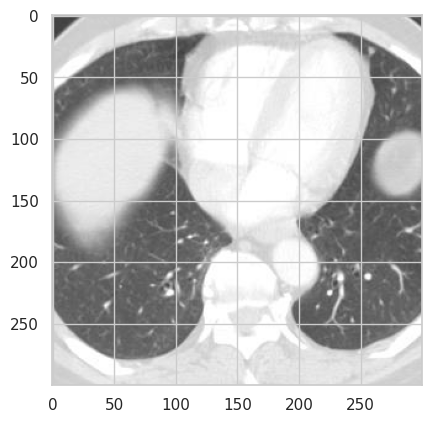

In [85]:
plt.imshow(center_cropped_img,cmap='gray')

1/1 [==============================] - 0s 144ms/step
yes


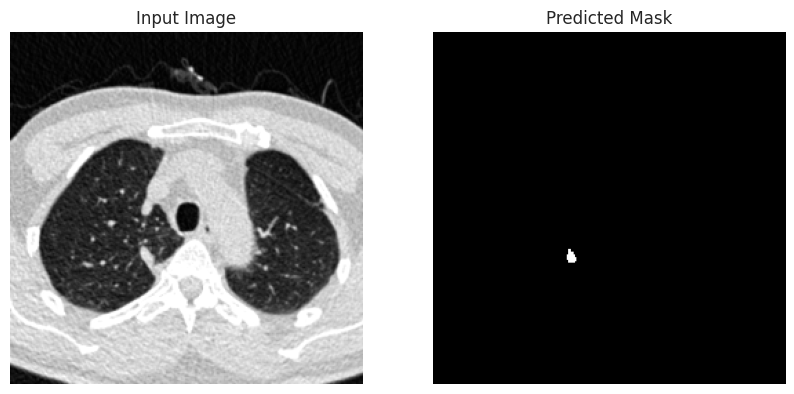

Saved mask for Bengin case (119).jpg in ./benign_masks/Bengin case (119).jpg
1/1 [==============================] - 0s 161ms/step
yes


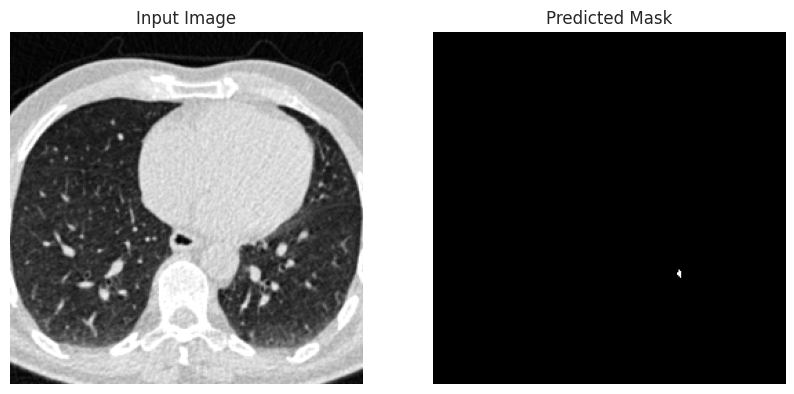

Saved mask for Bengin case (111).jpg in ./benign_masks/Bengin case (111).jpg
1/1 [==============================] - 0s 151ms/step
yes


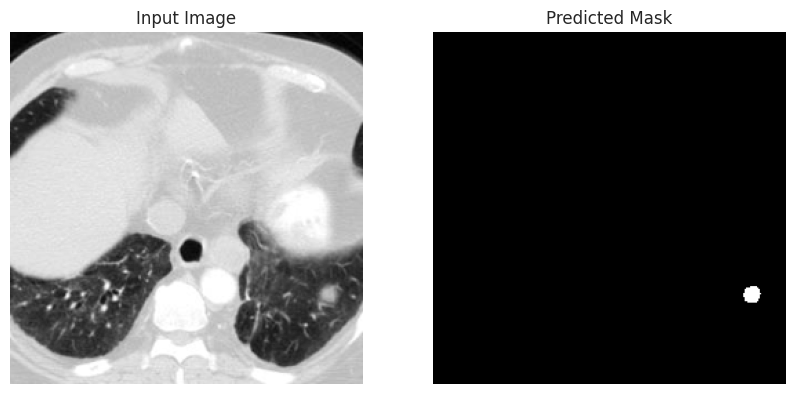

Saved mask for 000075_1.jpg in ./benign_masks/000075_1.jpg
1/1 [==============================] - 0s 142ms/step
yes


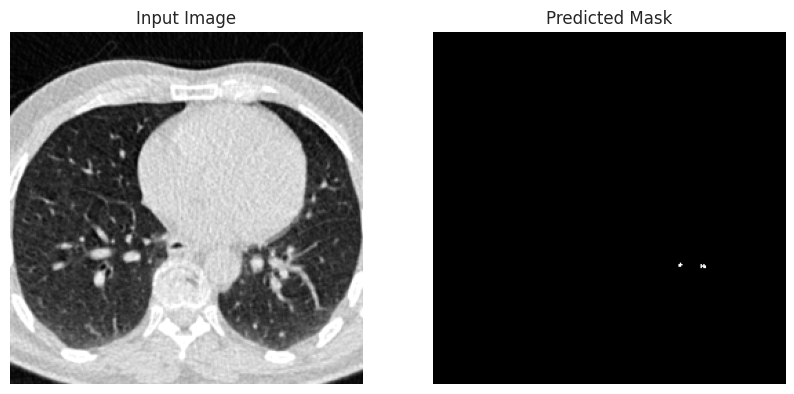

Saved mask for Bengin case (116).jpg in ./benign_masks/Bengin case (116).jpg
1/1 [==============================] - 0s 140ms/step
yes


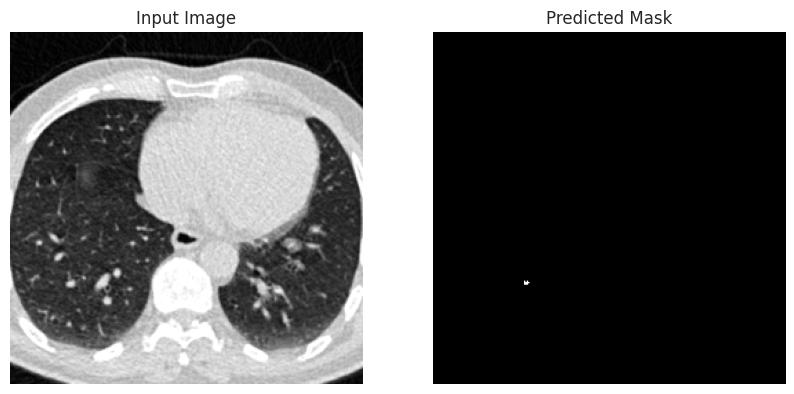

Saved mask for Bengin case (112).jpg in ./benign_masks/Bengin case (112).jpg
1/1 [==============================] - 0s 157ms/step
yes


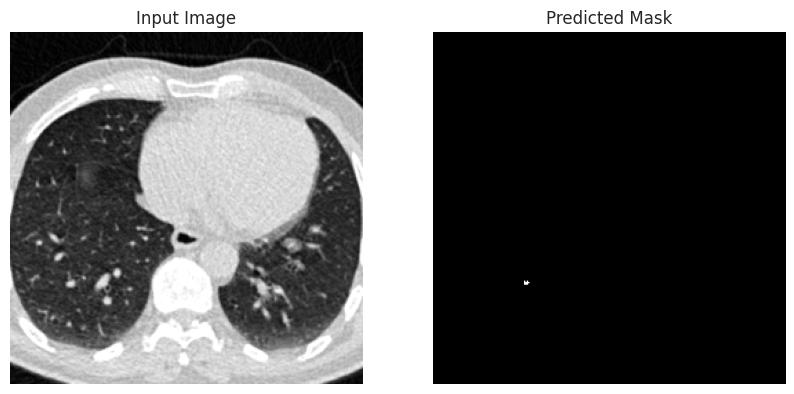

Saved mask for Bengin case (113).jpg in ./benign_masks/Bengin case (113).jpg
1/1 [==============================] - 0s 155ms/step
yes


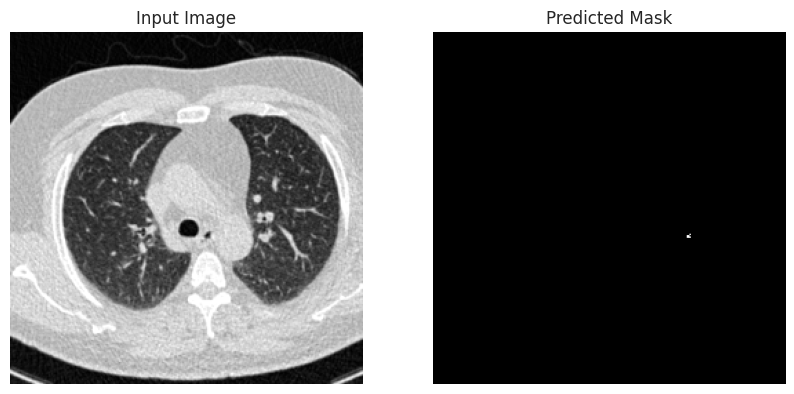

Saved mask for Bengin case (100).jpg in ./benign_masks/Bengin case (100).jpg
1/1 [==============================] - 0s 149ms/step


In [87]:
#reminder to self...dont get lost....this is for the third dataset...here the images need to be cropped to get rid of the text 
import os
import cv2
import numpy as np
import tensorflow as tf  # or any other framework you are using for the model
import matplotlib.pyplot as plt


# Replace 'input_folder' and 'output_folder' with the actual paths to your input and output folders
input_folder = '/kaggle/input/benign-but-annotated/Benign 2'
output_mask_folder = './benign_masks'
output_img_folder = './benign_images'
if not os.path.exists(output_mask_folder):
    os.makedirs(output_mask_folder)
if not os.path.exists(output_img_folder):
    os.makedirs(output_img_folder)

# Loop through the images in the input folder
for image_file in os.listdir(input_folder):
    if image_file.endswith(".jpg"):
        # Read the input image
        img_path = os.path.join(input_folder, image_file)
        img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
        
        target_size = 320
        h, w = img.shape

        # Calculate the starting and ending coordinates for the crop
        start_x = (w - target_size) // 2
        start_y = (h - target_size) // 2
        end_x = start_x + target_size
        end_y = start_y + target_size

        # Perform the center crop
        center_cropped_img = img[start_y:end_y, start_x:end_x]
        img = center_cropped_img
        img = cv2.resize(img, (256, 256))
        
        #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = img/255.0

        # Perform prediction
        
        prediction = model.predict(np.expand_dims(img, axis=0))[0]  # Make sure the input shape matches the model
        prediction_ = ((np.squeeze(prediction,axis=0)>0.7).astype(np.uint8)*255)
        if np.any(prediction_ > 0):
            print('yes')
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(img,cmap='gray')
            ax[0].set_title('Input Image')
            ax[0].axis('off')
            ax[1].imshow(prediction_, cmap='gray')  # You might need to adjust the cmap depending on your output format
            ax[1].set_title('Predicted Mask')
            ax[1].axis('off')
            plt.show()
       
            output_path = os.path.join(output_img_folder, image_file)
            cv2.imwrite(output_path, img)

            output_path = os.path.join(output_mask_folder, image_file)
            cv2.imwrite(output_path, prediction_)

            print(f"Saved mask for {image_file} in {output_path}")